# Imports

In [163]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [164]:
df = pd.read_csv("/home/saruo/Downloads/HistoricalQuotes.csv")

# Data Preprocessing

In [165]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [166]:
df.rename(columns={' Close/Last': 'Close($)'}, inplace=True)
df.rename(columns={' Open': 'Open($)'}, inplace=True)
df.rename(columns={' High': 'High($)'}, inplace=True)
df.rename(columns={' Low': 'Low($)'}, inplace=True)
df.rename(columns={' Volume': 'Volume'}, inplace=True)
df.rename(columns={' Date': 'Date'}, inplace=True)

df.head(5)

,Date,Close($),Volume,Open($),High($),Low($)
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [167]:
minmax = MinMaxScaler(feature_range=(0, 1))

In [168]:
for column in ['Close($)','Open($)','High($)','Low($)']:
  df[column] = pd.to_numeric(df[column].str.replace('[\$, ]', '', regex=True), errors='coerce')

df.head(5)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_29634/3564209834.py:2: SyntaxWarning: invalid escape sequence '\$'
  df[column] = pd.to_numeric(df[column].str.replace('[\$, ]', '', regex=True), errors='coerce')


,Date,Close($),Volume,Open($),High($),Low($)
0,02/28/2020,273.36,106721200,257.26,278.41,256.37
1,02/27/2020,273.52,80151380,281.10,286.00,272.96
2,02/26/2020,292.65,49678430,286.53,297.88,286.50
3,02/25/2020,288.08,57668360,300.95,302.53,286.13
4,02/24/2020,298.18,55548830,297.26,304.18,289.23


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2518 non-null   object 
 1   Close($)  2518 non-null   float64
 2   Volume    2518 non-null   int64  
 3   Open($)   2518 non-null   float64
 4   High($)   2518 non-null   float64
 5   Low($)    2518 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 118.2+ KB


In [170]:
close = df['Close($)']

df_mm=minmax.fit_transform(close.values.reshape(-1,1))

In [171]:
df_mm.shape

(2518, 1)

In [172]:
train_data, test_data = train_test_split(df_mm, test_size=0.2, random_state=42)

print(f"Dataset shape : {df_mm.shape}")
print(f"Training set shape : {train_data.shape}")
print(f"Testing set shape : {test_data.shape}")

Dataset shape : (2518, 1)
Training set shape : (2014, 1)
Testing set shape : (504, 1)


# Create Training Sequences

In [173]:
sequence_length = 60

X_train, y_train = [], []

for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print("Training sequences shape:", X_train.shape)
print("Training targets shape:", y_train.shape)


Training sequences shape: (1954, 60, 1)
Training targets shape: (1954,)


# Build the RNN Model

In [174]:
model = Sequential()

model.add(SimpleRNN(units=50,return_sequences=(X_train.shape[1],1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [175]:
fit_model = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    # verbose=1
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0587 - val_loss: 0.0406
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0458 - val_loss: 0.0400
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474 - val_loss: 0.0398
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 - val_loss: 0.0403
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0448 - val_loss: 0.0393
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443 - val_loss: 0.0393
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0455 - val_loss: 0.0390
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0444 - val_loss: 0.0404
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0448 - val_loss: 0.0395
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0435 - val_loss: 0.0390
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0438 - val_loss: 0.0391
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0430 - val_lo

# Make Predictions

In [176]:
test_data.shape

(504, 1)

In [177]:
y_pred = model.predict(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [178]:
y_pred

array([[[0.29418644]],

       [[0.2949863 ]],

       [[0.29491916]],

       [[0.29498574]],

       [[0.29451895]],

       [[0.2941048 ]],

       [[0.29389036]],

       [[0.2949998 ]],

       [[0.29471114]],

       [[0.2944302 ]],

       [[0.29423165]],

       [[0.29503316]],

       [[0.29471982]],

       [[0.2946316 ]],

       [[0.29440022]],

       [[0.29455993]],

       [[0.29477313]],

       [[0.2947515 ]],

       [[0.29474744]],

       [[0.29512048]],

       [[0.2943072 ]],

       [[0.29500332]],

       [[0.2945936 ]],

       [[0.29394504]],

       [[0.29485884]],

       [[0.29508403]],

       [[0.29509664]],

       [[0.29485646]],

       [[0.29477933]],

       [[0.2949401 ]],

       [[0.2939521 ]],

       [[0.29496863]],

       [[0.29490265]],

       [[0.2947611 ]],

       [[0.29511705]],

       [[0.29463294]],

       [[0.29507118]],

       [[0.29487517]],

       [[0.29507682]],

       [[0.2945138 ]],

       [[0.29477754]],

       [[0.29502

In [179]:
y_pred = y_pred.reshape(-1, 1)
# y_pred = minmax.inverse_transform(y_pred)
# actual_prices = minmax.inverse_transform(test_data)

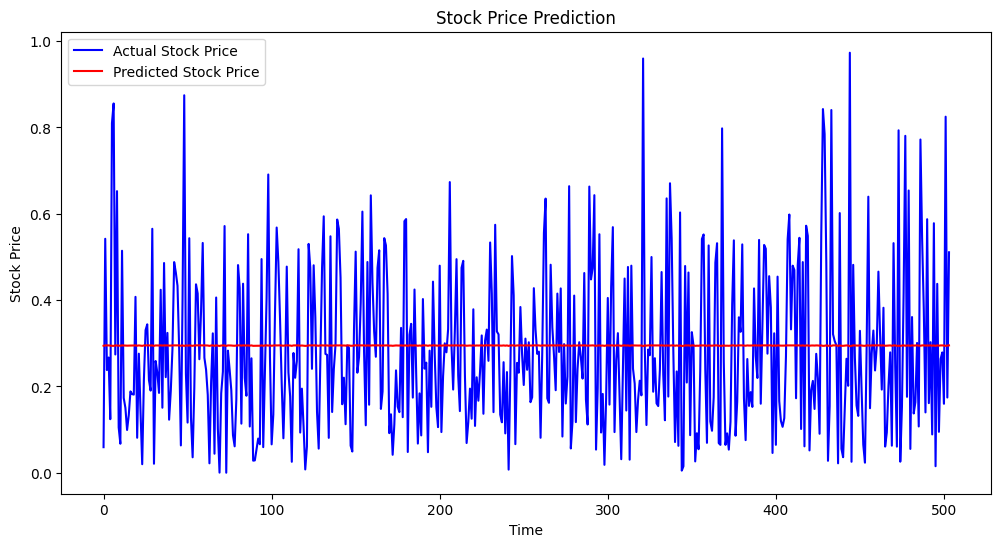

In [182]:
plt.figure(figsize=(12, 6))
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [183]:
mae = mean_absolute_error(test_data, y_pred)
rmse = np.sqrt(mean_squared_error(test_data, y_pred))


print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.15603807372218154
Root Mean Squared Error (RMSE): 0.19070816401135507
